In [1]:
import numpy as np
import json
from datetime import datetime

from shapely import geometry as sgeom
import geopandas as gpd
import ulmo
import pandas as pd
from collections import OrderedDict

In [2]:
#paths 
########## USER ###########
# Select modeling domain
domain = 'WY'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY_cso/'

metFname = 'mm_WY_2018-2019.dat'

In [3]:
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/Aragon2/Notebooks/calibration_python'
assimPath = '/nfs/attic/dfh/Aragon2/CSOassim/'+domain+'/'

#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()
    
#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()
    
#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)
    
#base .par
with open('/nfs/attic/dfh/Aragon2/CSOdmn/par_base.json') as f:
    base = json.load(f)

## SM run w/o assim 

This will be the baseline we will use to compare various assim runs

In [4]:
# setup SM run w/o assim
edit_par(base,'met_input_fname','../CSOdmn/'+domain+'/'+metFname)
edit_par(base,'iyear_init',metFname[6:10])
edit_par(base,'max_iter',(datetime.strptime(metFname[11:15]+'-09-30','%Y-%m-%d')-
                          datetime.strptime(metFname[6:10]+'-09-01','%Y-%m-%d')).days*4+4)

#run compile script 
#Compile SnowModel
%cd $codepath
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


## SM run assim 1/2 of SNOTEL

1/2 SNOTEL will be assimilated, 1/2 will not

Stations not assimilated will be used to evaluate enhanced performance of assimilation

In [4]:
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

In [5]:
#function to extract data
def sites_asgdf(ulmo_getsites, crs=stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [6]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

In [7]:
# WaterML/WOF WSDL endpoint url 
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)

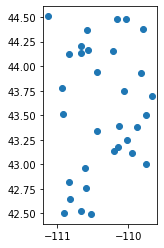

In [8]:
gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
gdf.drop(columns='index_right', inplace=True)
gdf.reset_index(drop=True, inplace=True)
#CSO_gdf.index = CSO_gdf['code']

#add columns with projected coordinates 
proj = gdf.to_crs(mod_proj)
gdf['easting'] = proj.geometry.x
gdf['northing'] = proj.geometry.y

gdf.plot()

### save out SWE data at all stations for this year to use as reference later 

In [14]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [15]:
st = metFname[6:10]+'-09-01'
ed = metFname[11:15]+'-09-30'

stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in gdf.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        #check for nan values
        if len(swe.value[np.isnan(swe.value)]) > 0:
            #check if more than 10% of data is missing
            if len(swe.value[np.isnan(swe.value)])/len(swe) > .1:
                print('More than 10% of days missing')
                gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)
                continue
        stn_swe[sitecode] = swe.value
    except:
        gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)

        
stn_swe

314_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
347_MT_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
350_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
353_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
379_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
419_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
421_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30


Unable to fetch SNOTEL:WTEQ_D
460_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
468_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
1082_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
497_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
499_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
506_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
944_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
555_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
577_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
585_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
597_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
661_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
689_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
730_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
764_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
765_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
779_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
806_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
807_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
816_WY_SNTL SNOTEL:WTEQ_D 2018-09-01 2019-09-30
822_WY_SN

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,878_WY_SNTL
2018-09-01,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-27,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-28,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,1.2,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-29,0.0,0.2,1.0,0.9,0.3,0.0,0.0,0.0,1.9,0.0,...,0.0,0.0,0.3,0.2,0.0,1.4,0.0,1.2,0.0,0.7


In [16]:
stn_swe = stn_swe*0.0254
stn_swe

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,379_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,878_WY_SNTL
2018-09-01,0.0,0.00000,0.00254,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
2018-09-02,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
2018-09-03,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
2018-09-04,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
2018-09-05,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.03302,0.0,...,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
2019-09-27,0.0,0.00000,0.01270,0.00000,0.00000,0.0,0.0,0.0,0.02540,0.0,...,0.0,0.0,0.00254,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
2019-09-28,0.0,0.00000,0.00508,0.00000,0.00000,0.0,0.0,0.0,0.03048,0.0,...,0.0,0.0,0.00254,0.00000,0.0,0.00000,0.0,0.00000,0.0,0.00000
2019-09-29,0.0,0.00508,0.02540,0.02286,0.00762,0.0,0.0,0.0,0.04826,0.0,...,0.0,0.0,0.00762,0.00508,0.0,0.03556,0.0,0.03048,0.0,0.01778


In [17]:
out = assimPath + 'SNOTEL_data_SWEDmeters'+st+'_'+ed+'.csv'
stn_swe.to_csv(out)

### create a random sample of half the snotel stations to use for assim 

In [10]:
sample = gdf.sample(n=int(len(gdf)/2))

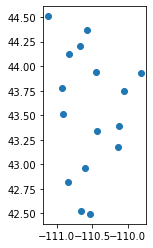

In [11]:
sample.plot()

In [12]:
sample

,code,longitude,latitude,name,elevation_m,geometry,easting,northing
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,POINT (-110.60973 42.96400),531828.554679,4.756891e+06
19,689_WY_SNTL,-110.912582,43.516869,Phillips Bench,2499.360107421875,POINT (-110.91258 43.51687),507065.249634,4.818218e+06
15,577_WY_SNTL,-110.666283,44.208618,Lewis Lake Divide,2392.679931640625,POINT (-110.66628 44.20862),526661.568381,4.895098e+06
26,816_WY_SNTL,-110.577171,44.369171,Thumb Divide,2432.303955078125,POINT (-110.57717 44.36917),533689.015354,4.912964e+06
30,868_WY_SNTL,-110.835152,42.815128,Willow Creek,2462.783935546875,POINT (-110.83515 42.81513),513476.729981,4.740299e+06
12,506_WY_SNTL,-110.129433,43.389389,Gros Ventre Summit,2667,POINT (-110.12943 43.38939),570508.936652,4.804425e+06
27,822_WY_SNTL,-110.057800,43.749020,Togwotee Pass,2919.98388671875,POINT (-110.05780 43.74902),575857.882766,4.844429e+06
9,1082_WY_SNTL,-110.927834,43.779331,Grand Targhee,2822.447998046875,POINT (-110.92783 43.77933),505807.281569,4.847367e+06
22,765_WY_SNTL,-110.532028,42.494900,Snider Basin,2456.68798828125,POINT (-110.53203 42.49490),538454.595933,4.704833e+06
31,878_WY_SNTL,-109.817749,43.932251,Younts Peak,2545.080078125,POINT (-109.81775 43.93225),594893.973880,4.865027e+06


In [18]:
#reset index
sample = sample.reset_index(drop=True)

# select swe data for sample 
sample_swe = pd.DataFrame() 
for station in sample.code:
    sample_swe[station] = stn_swe[station]
sample_swe

,353_WY_SNTL,689_WY_SNTL,577_WY_SNTL,816_WY_SNTL,868_WY_SNTL,506_WY_SNTL,822_WY_SNTL,1082_WY_SNTL,765_WY_SNTL,878_WY_SNTL,347_MT_SNTL,597_WY_SNTL,499_WY_SNTL,497_WY_SNTL,314_WY_SNTL,779_WY_SNTL
2018-09-01,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-02,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-03,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-04,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-05,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,0.00000,0.00000,0.0,0.0,0.0,0.00508,0.00000,0.03302,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2019-09-27,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.02540,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2019-09-28,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.03048,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2019-09-29,0.02286,0.02540,0.0,0.0,0.0,0.01016,0.03556,0.04826,0.0,0.01778,0.00508,0.0,0.0,0.0,0.0,0.0


In [19]:
new = sample_swe
new

,353_WY_SNTL,689_WY_SNTL,577_WY_SNTL,816_WY_SNTL,868_WY_SNTL,506_WY_SNTL,822_WY_SNTL,1082_WY_SNTL,765_WY_SNTL,878_WY_SNTL,347_MT_SNTL,597_WY_SNTL,499_WY_SNTL,497_WY_SNTL,314_WY_SNTL,779_WY_SNTL
2018-09-01,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-02,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-03,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-04,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2018-09-05,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,0.00000,0.00000,0.0,0.0,0.0,0.00508,0.00000,0.03302,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2019-09-27,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.02540,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2019-09-28,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.03048,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
2019-09-29,0.02286,0.02540,0.0,0.0,0.0,0.01016,0.03556,0.04826,0.0,0.01778,0.00508,0.0,0.0,0.0,0.0,0.0


### get data from every 10th day 

In [18]:
new = sample_swe.iloc[::10, :]
#new = new.reset_index(drop=True)
new

,585_WY_SNTL,419_WY_SNTL,555_WY_SNTL,878_WY_SNTL,506_WY_SNTL,499_WY_SNTL,807_WY_SNTL,730_WY_SNTL,1082_WY_SNTL,837_WY_SNTL,577_WY_SNTL,764_WY_SNTL,350_WY_SNTL,597_WY_SNTL,779_WY_SNTL
2018-09-01,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00254,0.00000,0.00000
2018-09-11,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-09-21,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-10-01,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-10-11,0.00000,0.00000,0.00000,0.00000,0.00000,0.00508,0.01016,0.00254,0.02540,0.02032,0.00000,0.00000,0.02032,0.00000,0.00254
2018-10-21,0.00508,0.00000,0.00000,0.00508,0.00000,0.00000,0.00000,0.00000,0.04064,0.05080,0.00000,0.00000,0.04064,0.00000,0.01270
2018-10-31,0.00000,0.00000,0.00000,0.00000,0.00508,0.00508,0.00508,0.00000,0.07112,0.07112,0.00508,0.00000,0.07366,0.00000,0.00000
2018-11-10,0.01270,0.06096,0.01524,0.02794,0.01778,0.05334,0.03810,0.01016,0.19050,0.12446,0.04826,0.03048,0.14224,0.03556,0.06604
2018-11-20,0.03810,0.06858,0.02032,0.04064,0.03048,0.06858,0.04318,0.01778,0.20320,0.13716,0.05080,0.03810,0.15748,0.05080,0.07112
2018-11-30,0.04572,0.12192,0.05588,0.07620,0.05842,0.15240,0.08890,0.05842,0.33782,0.20574,0.13716,0.08890,0.21336,0.09144,0.13462


In [20]:
# save out stations being assimilated
out = assimPath + 'assim_SNOTEL_sites_12_19.geojson'
sample.to_file(out, driver='GeoJSON')


In [21]:
outFpath = 'swe_obs_test.dat'
f= open(outFpath,"w+")
 
    

tot_obs=np.shape(new)[0]*np.shape(new)[1]
uq_day = np.shape(new)[0]
stn = list(new.columns)
f.write('{:02.0f}\n'.format(uq_day))
for j in range(uq_day):
    d=new.index[j].day
    m=new.index[j].month
    y=new.index[j].year
    date = str(y)+' '+str(m)+' '+str(d)
    stn_count = np.shape(new)[1]
    f.write(date+' \n')
    f.write(str(stn_count)+' \n')
    ids = 100
    for k in range(stn_count):
        ids = ids + 1 
        if sample.code[0]==stn[0]:
            x= sample.easting[k]
            y=sample.northing[k]
            swe=new[stn[k]][j]
            f.write('{:3.0f}\t'.format(ids)+'{:10.0f}\t'.format(x)+'{:10.0f}\t'.format(y)+'{:3.2f}\n'.format(swe))
        else:
            print('station mismatch')
f.close() 

In [22]:
uq_day

395

In [23]:
assimpath = SMpath+'swe_assim/'
! mv swe_obs_test.dat $assimpath

In [24]:
edit_par(base,'irun_data_assim',1)
edit_par(base,'print_var_18','y')#swed
edit_par(base,'print_var_19','y')#sspr
edit_par(base,'print_var_20','y')#ssmt

replace_line(incFile, 30, '      parameter (max_obs_dates='+str(uq_day+1)+')\n')

In [25]:
%cd $codepath
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY_snotel/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


# SM run assim CSO 

In [5]:


CSO_obs = assimPath+'CSO_assim_2018-2019_all_csoid.csv'
CSO_gdf = pd.read_csv(CSO_obs)
CSO_gdf

,Unnamed: 0,geometry,id,author,depth,source,timestamp,elevation,x_idx,y_idx,...,lc,dt,Y,M,D,LON,LAT,H,swe,doy
0,135,POINT (-110.597818510855 43.6701724330154),D3gyiOmE,Katie O’Connell,10.00,MountainHub,2019-04-25T02:25:30.037Z,2131.137695,452,1023,...,6.0,2019-04-25,2019,4,25,-110.597819,43.670172,100.0,0.033626,207
1,136,POINT (-110.598540829639 43.6706713863815),SEJG7WBM,Katie O’Connell,72.00,MountainHub,2019-04-25T02:24:32.498Z,2127.995361,451,1023,...,6.0,2019-04-25,2019,4,25,-110.598541,43.670671,720.0,0.245734,207
2,137,POINT (-110.593582727118 43.6701536877488),Vn9QgQA7,Leanne,27.94,MountainHub,2019-04-24T15:56:24.335Z,2146.224609,455,1023,...,2.0,2019-04-24,2019,4,24,-110.593583,43.670154,279.4,0.094851,206
3,138,POINT (-110.591223958083 43.670516817875),xlFXLIST,Leanne,25.40,MountainHub,2019-04-24T15:53:28.932Z,2156.758057,457,1023,...,1.0,2019-04-24,2019,4,24,-110.591224,43.670517,254.0,0.086550,206
4,139,POINT (-110.598580352962 43.667640969849),4EMEMrPA,Colton Lewer,60.00,MountainHub,2019-04-24T15:53:19.864Z,2188.988770,451,1026,...,1.0,2019-04-24,2019,4,24,-110.598580,43.667641,600.0,0.203867,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,440,POINT (-110.941374 43.789676),RlB3wF6G,Fred Most,56.00,SnowPilot,2018-11-12T16:39:00.000Z,2760.414795,175,891,...,1.0,2018-11-12,2018,11,12,-110.941374,43.789676,560.0,0.117115,43
306,441,POINT (-110.95167 43.478566),6+xKcZFv,Chris McCollister,68.00,SnowPilot,2018-11-09T00:20:00.000Z,2794.276123,167,1237,...,1.0,2018-11-09,2018,11,9,-110.951670,43.478566,680.0,0.137963,40
307,442,POINT (-110.850197 43.605528),7MKrMQAz,Josh Pope,95.00,SnowPilot,2018-11-08T17:30:00.000Z,2773.990234,248,1096,...,6.0,2018-11-08,2018,11,8,-110.850197,43.605528,950.0,0.193702,39
308,443,POINT (-110.855482 43.602289),BBqIOtV3,Mike Rheam,65.00,SnowPilot,2018-11-08T17:00:00.000Z,2794.865967,244,1099,...,12.0,2018-11-08,2018,11,8,-110.855482,43.602289,650.0,0.134792,39


In [9]:
#1 year simulations 
outFpath = assimPath+'CSO_assim_2018-2019_all_minelevbiasid.dat'
f= open(outFpath,"w+")

tot_obs=len(CSO_gdf)
uq_day = np.unique(CSO_gdf.dt)
num_days = len(uq_day)
ids = 100
f.write('{:02.0f}\n'.format(num_days))
for j in range(len(uq_day)):
    obs = CSO_gdf[CSO_gdf['dt']==uq_day[j]]
    d=CSO_gdf.D[CSO_gdf['dt']==uq_day[j]].values
    m=CSO_gdf.M[CSO_gdf['dt']==uq_day[j]].values
    y=CSO_gdf.Y[CSO_gdf['dt']==uq_day[j]].values
    date = str(y[0])+' '+str(m[0])+' '+str(d[0])
    obs_count = str(len(obs))
    f.write(date+' \n')
    f.write(obs_count+' \n')
    for k in range(len(obs)):
        ids = ids+1
        x= obs.x[obs.index[k]]
        y=obs.y[obs.index[k]]
        swe=obs.swe[obs.index[k]]
        f.write('{:3.0f}\t'.format(ids)+'{:10.0f}\t'.format(x)+'{:10.0f}\t'.format(y)+'{:3.2f}\n'.format(swe))
f.close() 

In [6]:
CSO_obs

'/nfs/attic/dfh/Aragon2/CSOassim/WY/CSO_assim_2018-2019_all_minelevbiasid.csv'

In [18]:
CSOdata = assimPath+'CSO_assim_2018-2019_all_csoid.dat'
assimpath = SMpath+'swe_assim/swe_obs_test.dat'
! cp $CSOdata $assimpath

In [6]:
replace_line(incFile, 30, '      parameter (max_obs_dates='+str(len(CSO_gdf)+1)+')\n')
edit_par(base,'print_var_18','y')#swed
edit_par(base,'print_var_19','y')#sspr
edit_par(base,'print_var_20','y')#ssmt
edit_par(base,'irun_data_assim',1)

%cd $codepath
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWY_cso_id/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python
